In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import missingno as msno
from scipy.stats import randint
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, MultiLabelBinarizer
import ast
from gensim.models import KeyedVectors
from gensim import models
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.impute import KNNImputer


In [2]:
processed_df=pd.read_csv('final_data_processed.csv')

In [3]:
processed_df.describe()

,gross_earnings_domestic,theatres,earnings_per_theatre,budget,popularity,revenue,runtime,vote_average,vote_count,Specific Rotten Tomato Score,Views,Likes,Comments,Sentimental_Score
count,2.087000e+03,2087.000000,2087.000000,2.087000e+03,2087.000000,2.087000e+03,2087.000000,2087.000000,2087.000000,2087.000000,2.087000e+03,2.087000e+03,2.087000e+03,1901.000000
mean,4.435059e+07,60312.331576,inf,3.510298e+07,39.308373,1.154246e+08,110.385242,6.574123,2599.659320,62.377096,3.575611e+07,2.540692e+05,1.146286e+04,0.868804
std,8.549162e+07,66489.064589,NaN,5.408353e+07,62.848076,2.331514e+08,19.188726,0.915049,3870.105423,27.214607,1.615791e+08,1.004551e+06,5.224499e+04,0.415672
min,1.300000e+01,0.000000,2.218750,0.000000e+00,0.600000,7.000000e+00,5.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-0.999000
25%,9.729315e+05,3437.000000,237.172006,1.000000e+05,15.497500,3.415498e+06,97.000000,6.100000,290.000000,40.000000,1.176018e+06,6.676000e+03,2.955000e+02,0.978800
50%,1.190114e+07,39991.000000,392.688799,1.300000e+07,23.914000,2.600000e+07,107.000000,6.632000,1103.000000,67.000000,5.023623e+06,2.727800e+04,1.389000e+03,0.993900
75%,4.879339e+07,97363.000000,626.284255,4.000000e+07,41.421000,1.130511e+08,120.000000,7.160500,3165.500000,87.000000,1.663563e+07,1.014800e+05,5.321000e+03,0.997600
max,8.583730e+08,481782.000000,inf,4.600000e+08,1064.930000,2.800000e+09,206.000000,10.000000,33016.000000,100.000000,3.282427e+09,1.581956e+07,1.348414e+06,0.999900


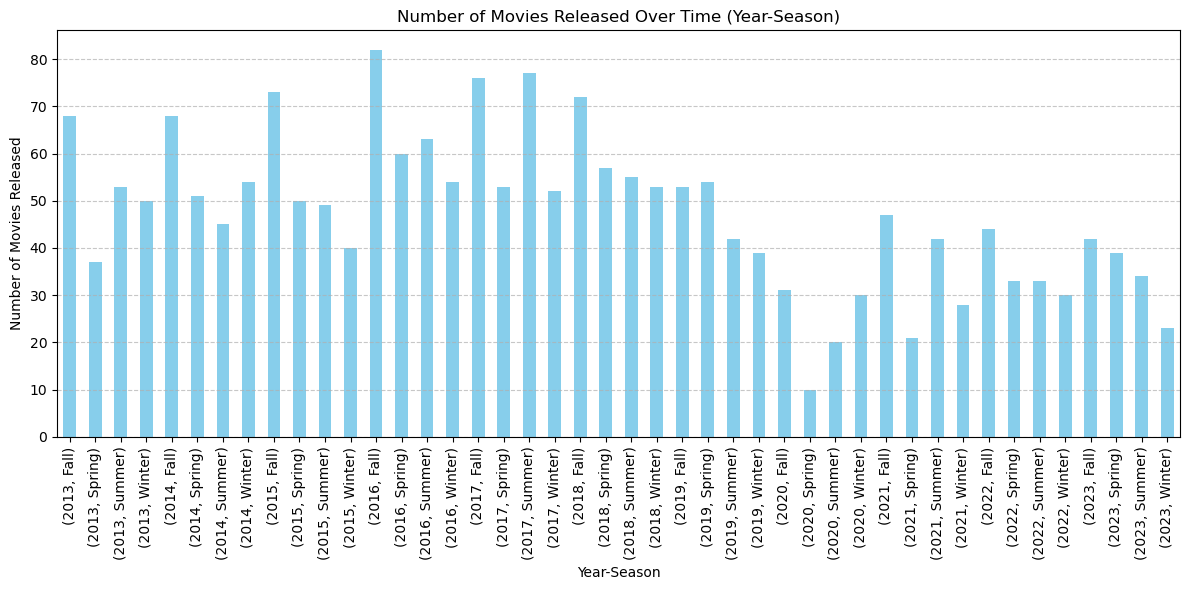

In [4]:
processed_df['release_date'] = pd.to_datetime(processed_df['release_date'])

# Define a function to get the season for a given date
def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

# Apply the get_season function to create a 'season' column in the DataFrame
processed_df['season'] = processed_df['release_date'].apply(get_season)

# Group the data by release year and season and count the number of movies released in each period
season_counts = processed_df.groupby([processed_df['release_date'].dt.year, processed_df['season']]).size()

# Create the bar chart
plt.figure(figsize=(12, 6))
season_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Year-Season')
plt.ylabel('Number of Movies Released')
plt.title('Number of Movies Released Over Time (Year-Season)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

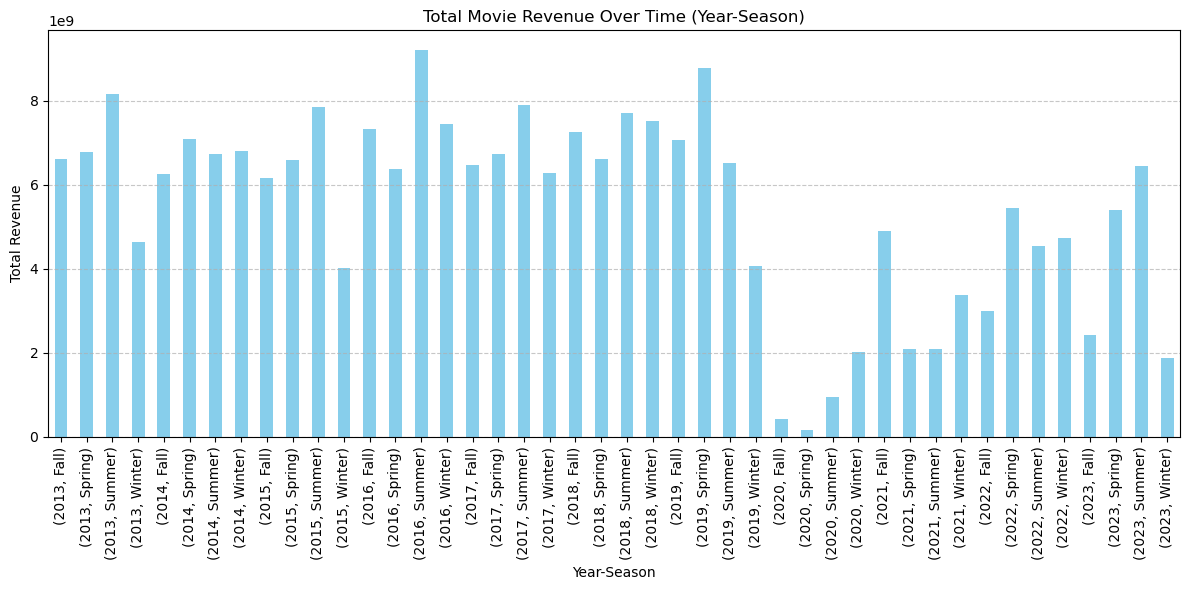

In [5]:
# Group the data by release year and season and sum the revenue for movies released in each period
season_revenue = processed_df.groupby([processed_df['release_date'].dt.year, processed_df['season']])['revenue'].sum()

# Create the bar chart for movie revenue
plt.figure(figsize=(12, 6))
season_revenue.plot(kind='bar', color='skyblue')
plt.xlabel('Year-Season')
plt.ylabel('Total Revenue')
plt.title('Total Movie Revenue Over Time (Year-Season)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


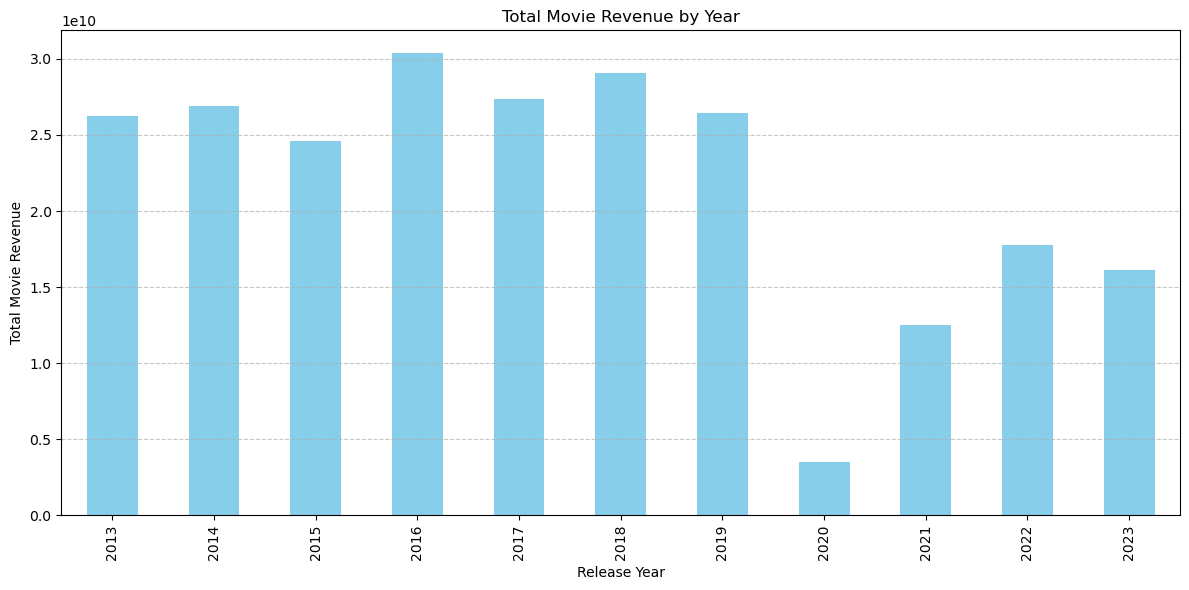

In [6]:
# Extract the year from the 'release_date' column and create a new 'release_year' column
processed_df['release_year'] = processed_df['release_date'].dt.year

# Group the data by release year and sum the movie revenue for each year
yearly_revenue = processed_df.groupby('release_year')['revenue'].sum()

# Create a bar chart for movie revenue by year
plt.figure(figsize=(12, 6))
yearly_revenue.plot(kind='bar', color='skyblue')
plt.xlabel('Release Year')
plt.ylabel('Total Movie Revenue')
plt.title('Total Movie Revenue by Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

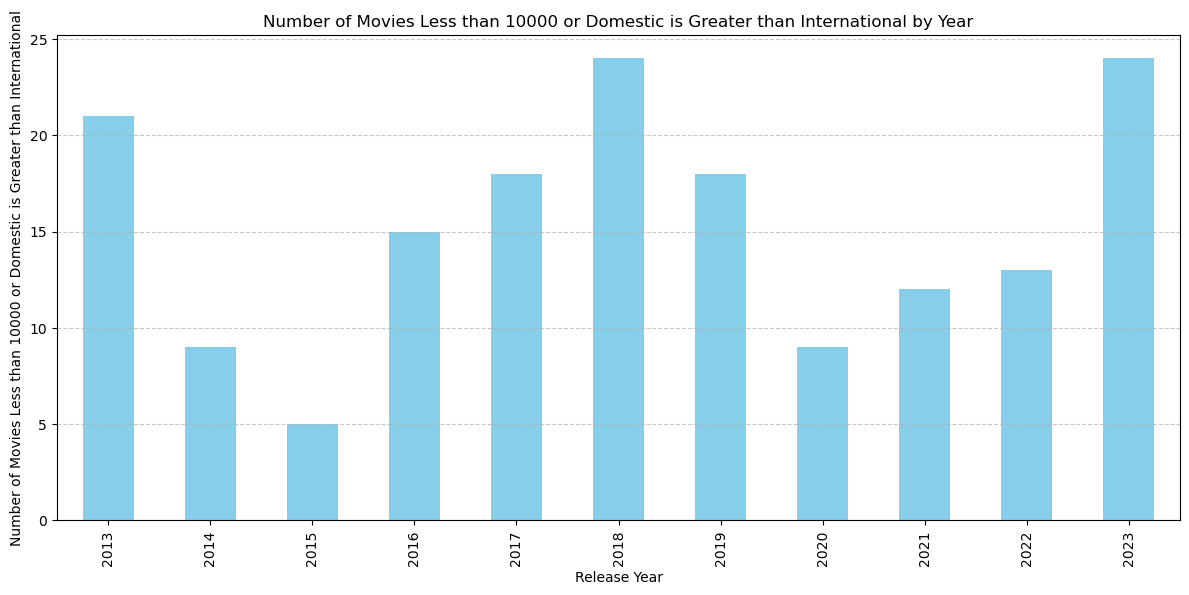

In [7]:
# Filter the DataFrame based on the conditions
filtered_df = processed_df[(processed_df['revenue'] < 10000) | (processed_df['revenue'] < processed_df['gross_earnings_domestic'])]

# Group the filtered data by release year and count the number of movies meeting the conditions for each year
movies_less_than_10000 = filtered_df.groupby(filtered_df['release_date'].dt.year)['movie'].count()

# Create a bar chart for the number of movies meeting the conditions by release year
plt.figure(figsize=(12, 6))
movies_less_than_10000.plot(kind='bar', color='skyblue')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies Less than 10000 or Domestic is Greater than International')
plt.title('Number of Movies Less than 10000 or Domestic is Greater than International by Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


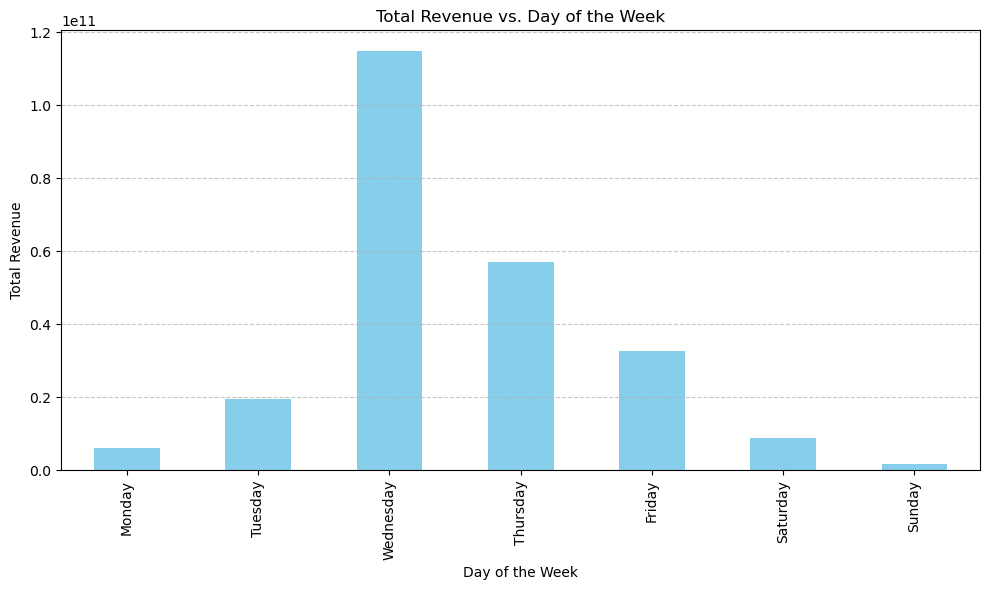

In [8]:

# Assuming your DataFrame is named 'processed_df'
processed_df['release_date'] = pd.to_datetime(processed_df['release_date'], errors='coerce')

# Extract the day of the week (0 = Monday, 6 = Sunday)
processed_df['day_of_week'] = processed_df['release_date'].dt.dayofweek

# Create a dictionary to map day of the week numbers to day names
day_names = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Map the day of the week numbers to day names
processed_df['day_of_week'] = processed_df['day_of_week'].map(day_names)

# Specify the order of the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group the data by day of the week and sum the revenue for each day
revenue_by_day = processed_df.groupby('day_of_week')['revenue'].sum().reindex(day_order)

# Create a bar plot to visualize the total revenue for each day of the week
plt.figure(figsize=(10, 6))
revenue_by_day.plot(kind='bar', color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Total Revenue')
plt.title('Total Revenue vs. Day of the Week')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


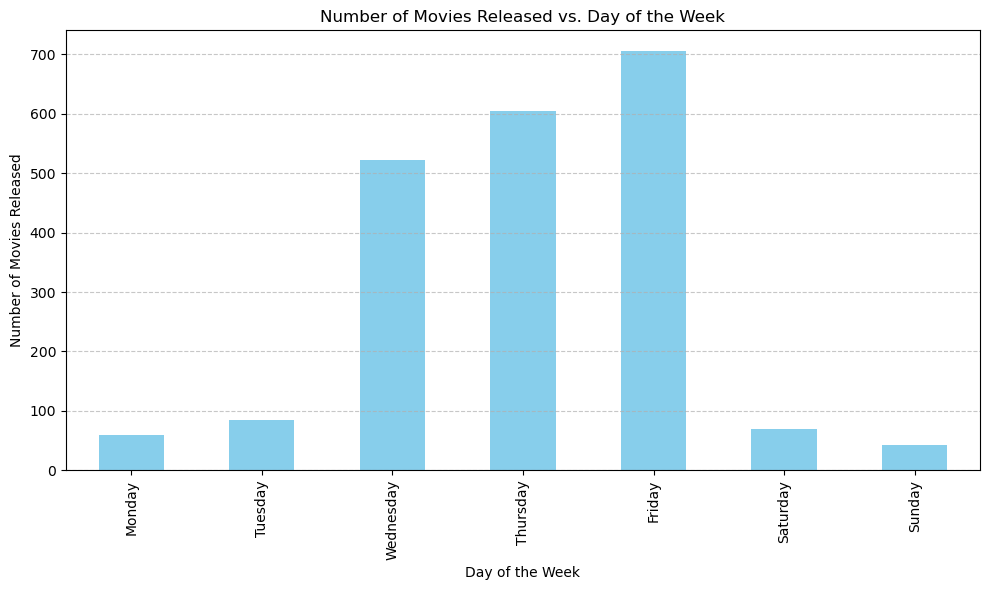

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'processed_df'
processed_df['release_date'] = pd.to_datetime(processed_df['release_date'], errors='coerce')

# Extract the day of the week (0 = Monday, 6 = Sunday)
processed_df['day_of_week'] = processed_df['release_date'].dt.dayofweek

# Create a dictionary to map day of the week numbers to day names
day_names = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Map the day of the week numbers to day names
processed_df['day_of_week'] = processed_df['day_of_week'].map(day_names)

# Specify the order of the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group the data by day of the week and count the number of movies for each day
movies_by_day = processed_df.groupby('day_of_week')['movie'].count().reindex(day_order)

# Create a bar plot to visualize the number of movies released on each day of the week
plt.figure(figsize=(10, 6))
movies_by_day.plot(kind='bar', color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Movies Released')
plt.title('Number of Movies Released vs. Day of the Week')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [10]:
# Filter the rows in processed_df based on the conditions
filtered_df = processed_df[(processed_df['revenue'] < 1000) | (processed_df['revenue'] < processed_df['gross_earnings_domestic'])]

# Print the selected columns for the filtered rows
print(filtered_df[['movie', 'revenue', 'release_date', 'gross_earnings_domestic']])

# Print the number of rows that meet the conditions
num_rows_changed = len(filtered_df)
num_rows_changed

                     movie   revenue release_date  gross_earnings_domestic
28            80 for Brady  29637811   2023-02-03               39330588.0
41        A Dog's Way Home  17643857   2019-01-10               41952715.0
50    A Journal for Jordan   6200000   2021-12-22                6545174.0
59       A Mouthful of Air    212833   2021-10-29                 269435.0
82                Acrimony  34764055   2018-03-30               43549096.0
...                    ...       ...          ...                      ...
2037               Whitney   1251945   2018-07-05                3026351.0
2072    You Won't Be Alone    125000   2022-04-01                 264055.0
2073           You're Next  14347000   2013-08-22               18494006.0
2076                 Youth   2000000   2015-05-20                2789478.0
2080                  Zola   3500000   2020-01-24                4862582.0

[145 rows x 4 columns]


145

In [11]:
##Remove 168 rows
processed_df = processed_df[(processed_df['revenue'] >= 10000) & (processed_df['revenue'] >= processed_df['gross_earnings_domestic'])]


In [12]:
#Budget

In [13]:
processed_df['budget'].describe()

count    1.919000e+03
mean     3.759699e+07
std      5.556752e+07
min      0.000000e+00
25%      2.000000e+06
50%      1.500000e+07
75%      4.500000e+07
max      4.600000e+08
Name: budget, dtype: float64

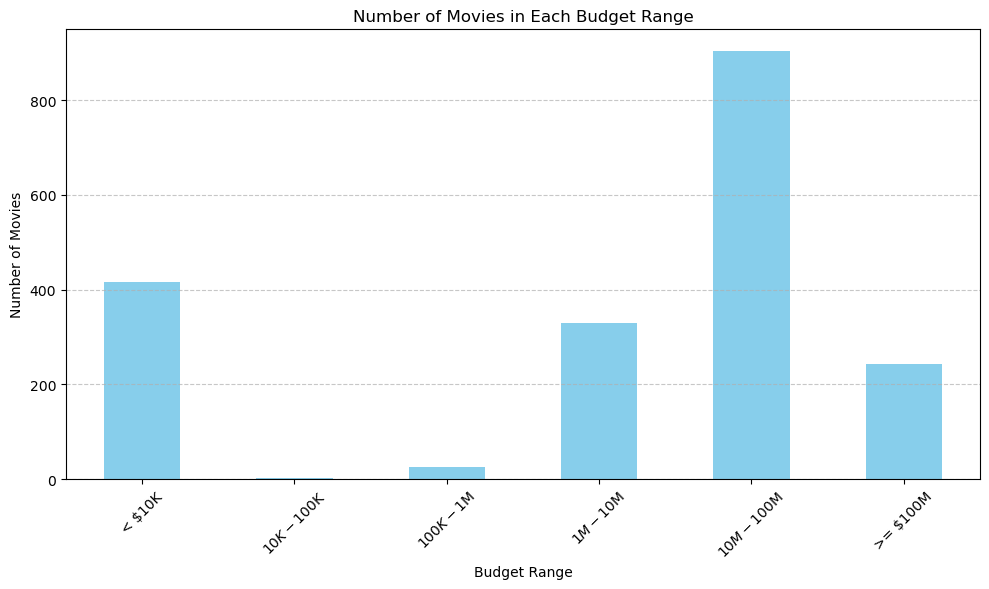

In [14]:

# Define the budget ranges and labels
budget_ranges = [(0, 10000), (10000, 100000), (100000, 1000000), (1000000, 10000000), (10000000, 100000000), (100000000, float('inf'))]
budget_range_labels = ['< $10K', '$10K-$100K', '$100K - $1M', '$1M - $10M', '$10M - $100M', '>= $100M']

# Create a new column 'budget_range' based on the budget ranges
processed_df['budget_range'] = pd.cut(processed_df['budget'], bins=[0, 10000, 100000, 1000000, 10000000, 100000000, float('inf')],
                                      labels=budget_range_labels, right=False, include_lowest=True)



# Group the data by 'budget_range' and count the number of movies in each range
budget_counts = processed_df.groupby('budget_range')['movie'].count()

# Create a bar chart to visualize the number of movies in each budget range
plt.figure(figsize=(10, 6))
budget_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Budget Range')
plt.ylabel('Number of Movies')
plt.title('Number of Movies in Each Budget Range')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [15]:

# Calculate the median of the 'budget' column
budget_median = processed_df['budget'].median()

# Replace values where 'budget' < 10000 with the calculated median
processed_df.loc[processed_df['budget'] < 10000, 'budget'] = budget_median


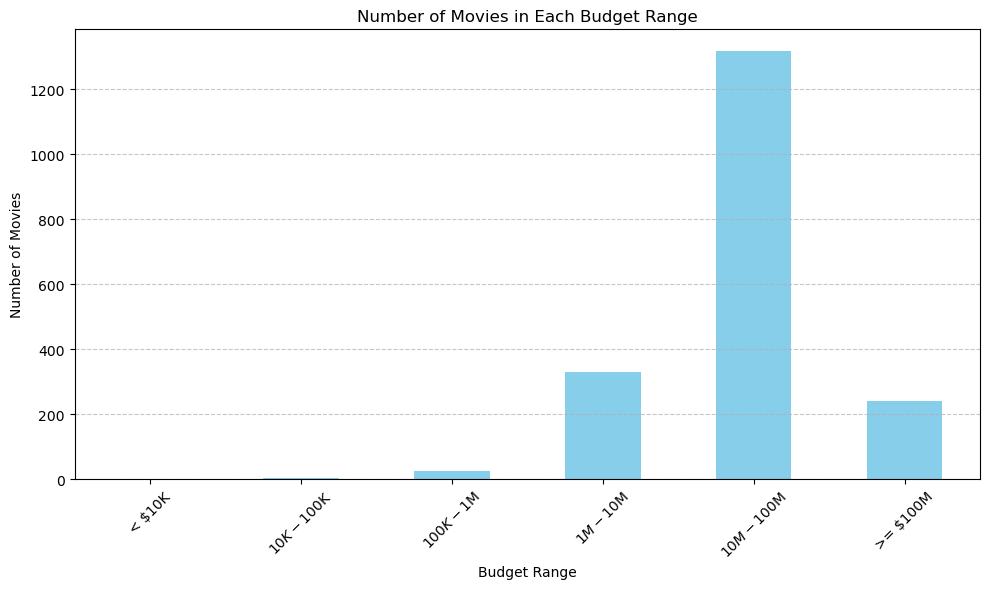

In [16]:

# Define the budget ranges and labels
budget_ranges = [(0, 10000), (10000, 100000), (100000, 1000000), (1000000, 10000000), (10000000, 100000000), (100000000, float('inf'))]
budget_range_labels = ['< $10K', '$10K-$100K', '$100K - $1M', '$1M - $10M', '$10M - $100M', '>= $100M']

# Create a new column 'budget_range' based on the budget ranges
processed_df['budget_range'] = pd.cut(processed_df['budget'], bins=[0, 10000, 100000, 1000000, 10000000, 100000000, float('inf')],
                                      labels=budget_range_labels, right=False, include_lowest=True)



# Group the data by 'budget_range' and count the number of movies in each range
budget_counts = processed_df.groupby('budget_range')['movie'].count()

# Create a bar chart to visualize the number of movies in each budget range
plt.figure(figsize=(10, 6))
budget_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Budget Range')
plt.ylabel('Number of Movies')
plt.title('Number of Movies in Each Budget Range')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [17]:
#ROI

In [18]:
processed_df['ROI']=((processed_df['revenue']-processed_df['budget'])/processed_df['budget'])

In [19]:
processed_df['ROI'].describe()


count    1919.000000
mean        2.606176
std        12.170459
min        -0.999318
25%        -0.572497
50%         0.703896
75%         2.898756
max       428.644100
Name: ROI, dtype: float64

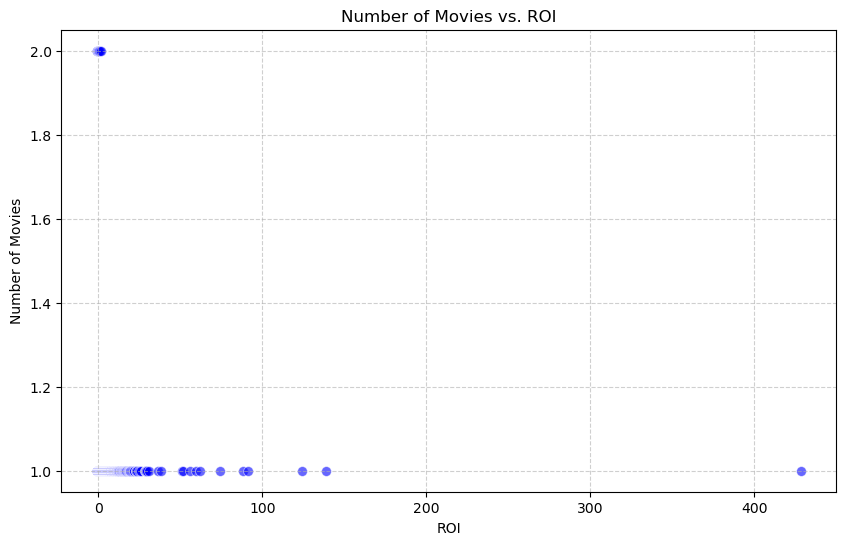

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the DataFrame by 'ROI' and count the number of movies in each 'ROI' group
roi_counts = processed_df['ROI'].value_counts().reset_index()
roi_counts.columns = ['ROI', 'Number of Movies']

# Sort the DataFrame by 'ROI' for a better visualization
roi_counts = roi_counts.sort_values(by='ROI')

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ROI', y='Number of Movies', data=roi_counts, marker='o', s=50, color='blue', alpha=0.6)
plt.xlabel('ROI')
plt.ylabel('Number of Movies')
plt.title('Number of Movies vs. ROI')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [21]:
# Assuming 'processed_df' contains your data

# Sort the DataFrame by 'ROI' in descending order and select the top 20 movies
top_5_movies = processed_df.nlargest(5, 'ROI')

top_5_movies[['movie','budget', 'revenue', 'ROI']]

,movie,budget,revenue,ROI
1629,The Gallows,100000,42964410,428.644100
1381,Skinamarink,15000,2100000,139.000000
485,Dragon Ball Super: Broly,1000000,125002821,124.002821
1610,The Farewell,250300,23076657,91.195993
1812,The Quiet Ones,200000,17834867,88.174335


In [22]:

max_roi_index = processed_df['ROI'].idxmax()

# Drop the row with the maximum "ROI" from the DataFrame
processed_df.drop(max_roi_index, inplace=True)


In [23]:
processed_df['ROI'].describe()

count    1918.000000
mean        2.384050
std         7.311939
min        -0.999318
25%        -0.572866
50%         0.699758
75%         2.896406
max       139.000000
Name: ROI, dtype: float64

In [24]:
top_5_movies = processed_df.nlargest(5, 'ROI')

top_5_movies[['movie','budget', 'revenue', 'ROI']]

,movie,budget,revenue,ROI
1381,Skinamarink,15000,2100000,139.000000
485,Dragon Ball Super: Broly,1000000,125002821,124.002821
1610,The Farewell,250300,23076657,91.195993
1812,The Quiet Ones,200000,17834867,88.174335
1341,Searching,1000000,75462037,74.462037


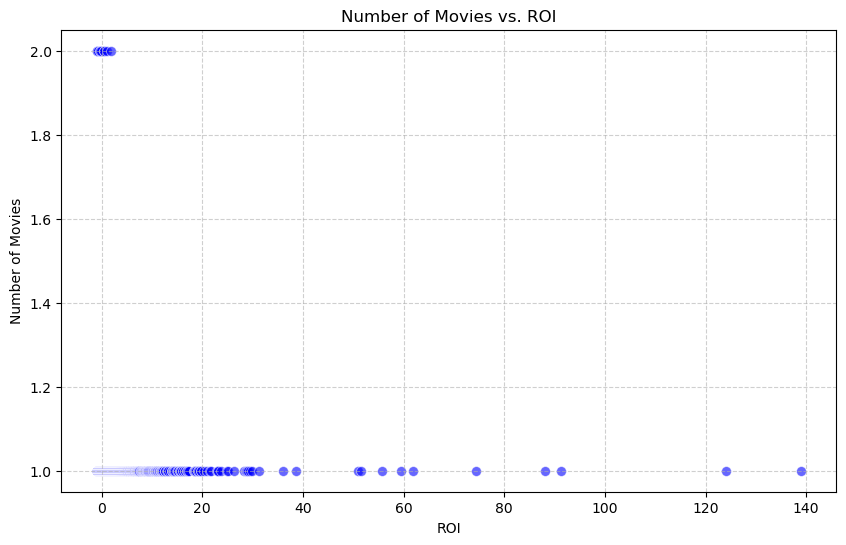

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the DataFrame by 'ROI' and count the number of movies in each 'ROI' group
roi_counts = processed_df['ROI'].value_counts().reset_index()
roi_counts.columns = ['ROI', 'Number of Movies']

# Sort the DataFrame by 'ROI' for a better visualization
roi_counts = roi_counts.sort_values(by='ROI')

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ROI', y='Number of Movies', data=roi_counts, marker='o', s=50, color='blue', alpha=0.6)
plt.xlabel('ROI')
plt.ylabel('Number of Movies')
plt.title('Number of Movies vs. ROI')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [26]:
##RunTime


In [27]:
processed_df['runtime'].describe()

count    1918.000000
mean      111.061522
std        19.116434
min        31.000000
25%        97.000000
50%       108.000000
75%       121.000000
max       206.000000
Name: runtime, dtype: float64

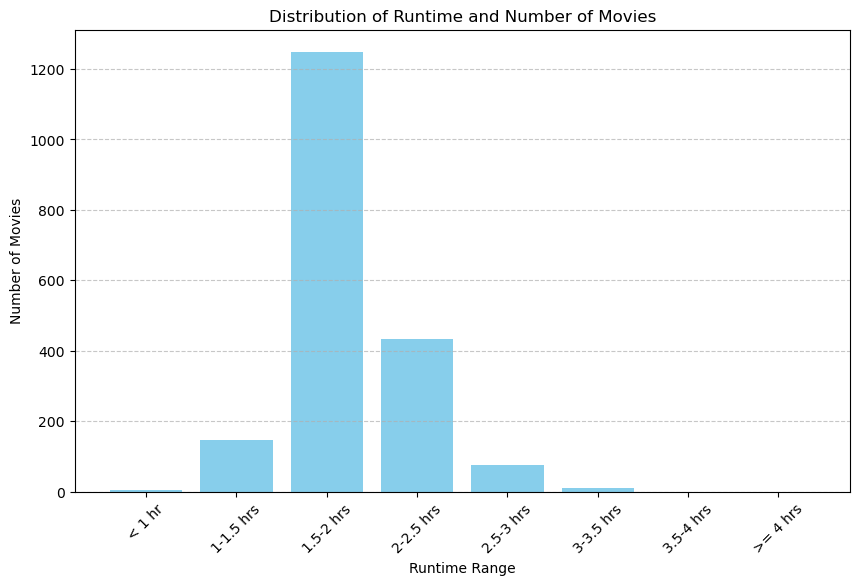

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the runtime bins and labels
runtime_bins = [0, 60, 90, 120, 150, 180, 210, 240, float('inf')]
runtime_labels = ['< 1 hr', '1-1.5 hrs', '1.5-2 hrs', '2-2.5 hrs', '2.5-3 hrs', '3-3.5 hrs', '3.5-4 hrs', '>= 4 hrs']

# Create a new column 'runtime_range' based on the runtime bins
processed_df['runtime_range'] = pd.cut(processed_df['runtime'], bins=runtime_bins, labels=runtime_labels, right=False, include_lowest=True)

# Count the number of movies in each runtime range
runtime_distribution = pd.value_counts(processed_df['runtime_range']).reset_index()
runtime_distribution.columns = ['Runtime Range', 'Number of Movies']

# Sort the table by runtime range
runtime_distribution = runtime_distribution.sort_values(by='Runtime Range')

# Create a bar chart to visualize the distribution
plt.figure(figsize=(10, 6))
plt.bar(runtime_distribution['Runtime Range'], runtime_distribution['Number of Movies'], color='skyblue')
plt.xlabel('Runtime Range')
plt.ylabel('Number of Movies')
plt.title('Distribution of Runtime and Number of Movies')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot


In [29]:
#Theatres

In [30]:
processed_df[processed_df['theatres']==0]

,movie,gross_earnings_domestic,theatres,earnings_per_theatre,belongs_to_collection,budget,genres,original_language,overview,popularity,...,Likes,Comments,Top 10 Comments,Sentimental_Score,season,release_year,day_of_week,budget_range,ROI,runtime_range
614,Gangubai Kathiawadi,592000.0,0.0,inf,NaN,12000000,"['Crime', 'Drama', 'History']",hi,"Duped and sold to a brothel, a young woman fea...",9.249,...,1360708,47327,Watch: Krack | New Released Full Hindi Dubbed ...,0.9988,Winter,2022,Thursday,$10M - $100M,1.108333,2.5-3 hrs
854,K.G.F: Chapter 2,2874000.0,0.0,inf,K.G.F Collection,13000000,"['Action', 'Adventure', 'Crime', 'Thriller']",kn,The blood-soaked land of Kolar Gold Fields (KG...,23.045,...,2737505,27256,"Watch Blockbuster Comedy Horror Film ""Aranmana...",0.9217,Spring,2022,Thursday,$10M - $100M,5.954673,2.5-3 hrs


In [31]:
# Create a copy of the DataFrame to work with
imputed_df = processed_df.copy()

# Initialize the KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors as needed

# Select the 'budget' column for imputation
budget_column = imputed_df[['budget']]

# Perform KNN imputation for the 'budget' column
budget_imputed = knn_imputer.fit_transform(budget_column)

# Update the 'budget' column in the DataFrame with the imputed values
processed_df['budget'] = budget_imputed

# Now 'budget' column contains imputed values


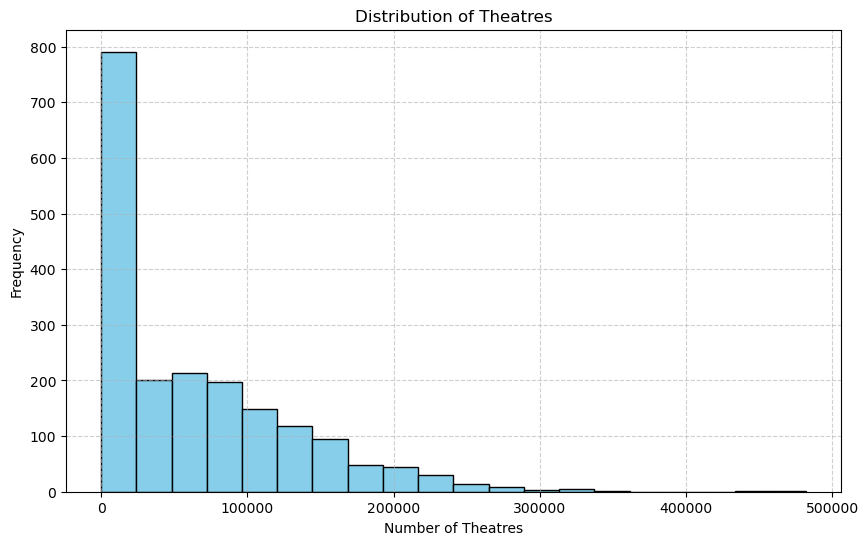

In [32]:
import matplotlib.pyplot as plt

# Create a histogram for the 'theatres' column
plt.figure(figsize=(10, 6))
plt.hist(processed_df['theatres'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Theatres')
plt.ylabel('Frequency')
plt.title('Distribution of Theatres')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [33]:
processed_df['popularity'].describe()

count    1918.000000
mean       41.147657
std        64.906708
min         0.600000
25%        16.455250
50%        25.205500
75%        43.448250
max      1064.930000
Name: popularity, dtype: float64

In [34]:
processed_df[processed_df['popularity']==processed_df['popularity'].max()]

,movie,gross_earnings_domestic,theatres,earnings_per_theatre,belongs_to_collection,budget,genres,original_language,overview,popularity,...,Likes,Comments,Top 10 Comments,Sentimental_Score,season,release_year,day_of_week,budget_range,ROI,runtime_range
1950,Trolls Band Together,63593725.0,38815.0,1638.380137,The Trolls Collection,95000000.0,"['Animation', 'Family', 'Music', 'Fantasy', 'C...",en,"When Branch’s brother, Floyd, is kidnapped for...",1064.93,...,22538,0,NaN,NaN,Fall,2023,Thursday,$10M - $100M,0.534737,1.5-2 hrs


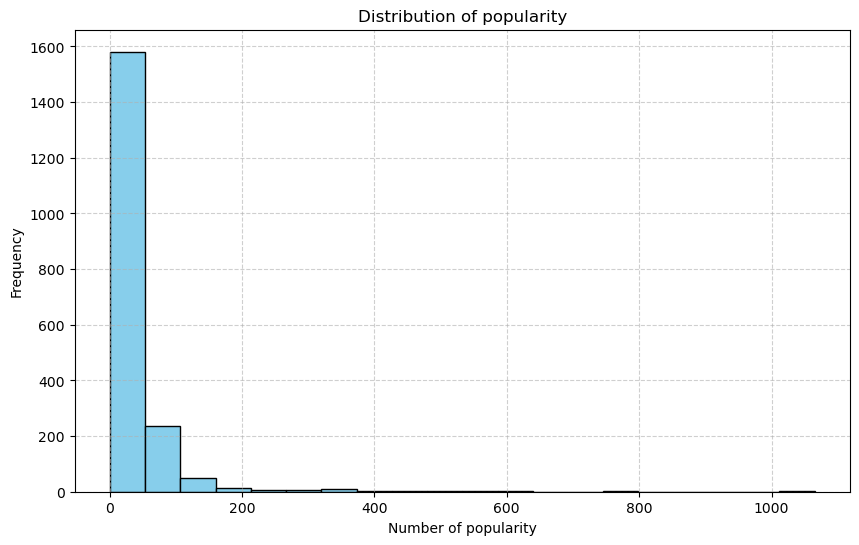

In [35]:
import matplotlib.pyplot as plt

# Create a histogram for the 'theatres' column
plt.figure(figsize=(10, 6))
plt.hist(processed_df['popularity'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of popularity')
plt.ylabel('Frequency')
plt.title('Distribution of popularity')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


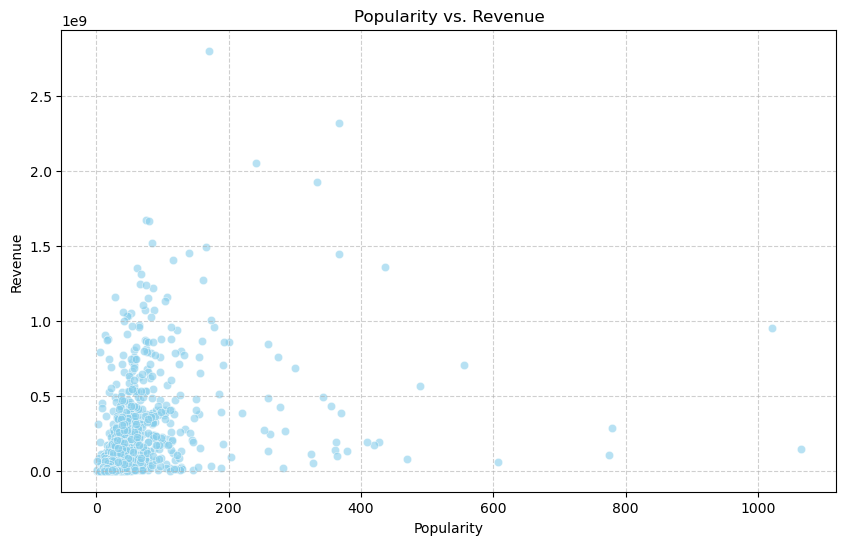

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'processed_df' contains your data

# Create a scatter plot of 'popularity' vs. 'revenue'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='popularity', y='revenue', data=processed_df, marker='o', color='skyblue', alpha=0.6)
plt.xlabel('Popularity')
plt.ylabel('Revenue')
plt.title('Popularity vs. Revenue')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [37]:
##Useless

In [38]:
processed_df['vote_average'].describe()

count    1918.000000
mean        6.618128
std         0.821628
min         0.000000
25%         6.110500
50%         6.652000
75%         7.174750
max         8.515000
Name: vote_average, dtype: float64

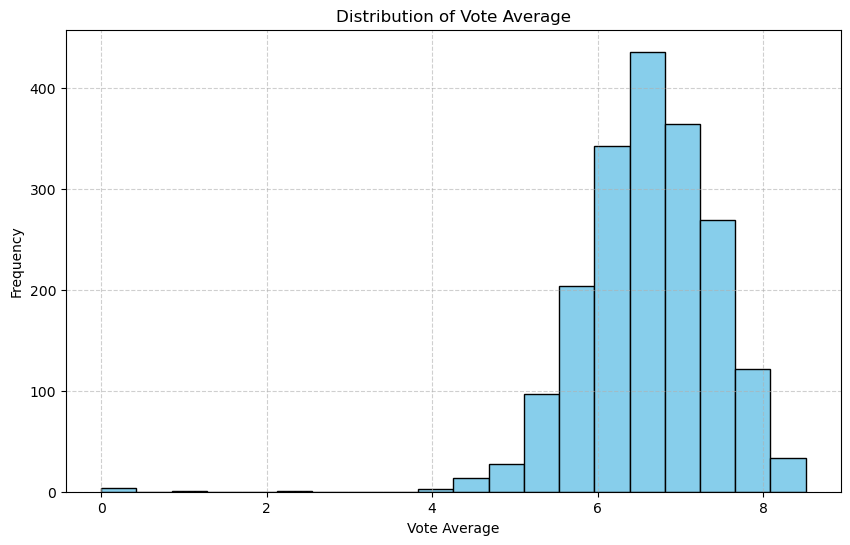

In [39]:

# Create a histogram for the 'vote_average' column
plt.figure(figsize=(10, 6))
plt.hist(processed_df['vote_average'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.title('Distribution of Vote Average')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [40]:
processed_df.describe()

,gross_earnings_domestic,theatres,earnings_per_theatre,budget,popularity,revenue,runtime,vote_average,vote_count,Specific Rotten Tomato Score,Views,Likes,Comments,Sentimental_Score,release_year,ROI
count,1.918000e+03,1918.000000,1918.000000,1.918000e+03,1918.000000,1.918000e+03,1918.000000,1918.000000,1918.000000,1918.000000,1.918000e+03,1.918000e+03,1918.000000,1743.000000,1918.000000,1918.000000
mean,4.689754e+07,62999.956204,inf,4.086210e+07,41.147657,1.248740e+08,111.061522,6.618128,2789.424922,62.388425,3.594060e+07,2.545472e+05,11196.065693,0.870236,2017.308133,2.384050
std,8.755420e+07,67528.863745,NaN,5.368887e+07,64.906708,2.408657e+08,19.116434,0.821628,3975.287860,27.234828,1.619695e+08,9.862790e+05,44319.054488,0.415605,2.950195,7.311939
min,8.800000e+01,0.000000,2.218750,1.500000e+04,0.600000,1.023200e+04,31.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,-0.999000,2013.000000,-0.999318
25%,1.156787e+06,4075.250000,248.584878,1.282088e+07,16.455250,4.883682e+06,97.000000,6.110500,366.250000,41.000000,1.260708e+06,7.202750e+03,316.250000,0.979200,2015.000000,-0.572866
50%,1.443631e+07,44340.000000,405.726303,1.500000e+07,25.205500,3.350552e+07,108.000000,6.652000,1271.000000,67.000000,5.374806e+06,2.877650e+04,1469.500000,0.993900,2017.000000,0.699758
75%,5.359307e+07,101431.750000,650.652657,4.500000e+07,43.448250,1.256815e+08,121.000000,7.174750,3441.500000,87.000000,1.758603e+07,1.075178e+05,5747.000000,0.997700,2019.000000,2.896406
max,8.583730e+08,481782.000000,inf,4.600000e+08,1064.930000,2.800000e+09,206.000000,8.515000,33016.000000,100.000000,3.282427e+09,1.581956e+07,730303.000000,0.999900,2023.000000,139.000000


In [41]:
processed_df['vote_count'].describe()

count     1918.000000
mean      2789.424922
std       3975.287860
min          0.000000
25%        366.250000
50%       1271.000000
75%       3441.500000
max      33016.000000
Name: vote_count, dtype: float64

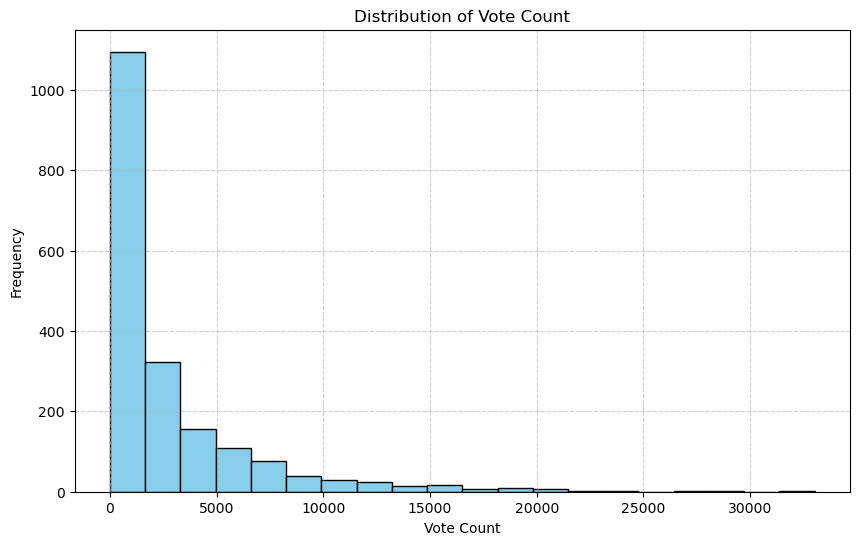

In [42]:

# Create a histogram for the 'vote_average' column
plt.figure(figsize=(10, 6))
plt.hist(processed_df['vote_count'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Vote Count')
plt.ylabel('Frequency')
plt.title('Distribution of Vote Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [43]:
processed_df[processed_df['vote_count']==0]

,movie,gross_earnings_domestic,theatres,earnings_per_theatre,belongs_to_collection,budget,genres,original_language,overview,popularity,...,Likes,Comments,Top 10 Comments,Sentimental_Score,season,release_year,day_of_week,budget_range,ROI,runtime_range
876,Kingdom Men Rising,1188936.0,1410.0,843.217021,NaN,300000.0,['Documentary'],en,Kingdom Men Rising is a documentary film explo...,1.382,...,1656,83,This film needs to be seen by everyone. It wi...,0.9946,Spring,2019,Monday,$100K - $1M,2.963120,1.5-2 hrs
969,Made for More,2999134.0,2545.0,1178.441650,NaN,15000000.0,['Documentary'],en,Are you ready for a girl’s night out unlike an...,1.176,...,166,4,"❤❤❤❤❤Grace 😊|, Unstoppable grace|, Can we get ...",0.2263,Winter,2018,Monday,$10M - $100M,-0.800058,2-2.5 hrs
1586,The Disappearance of Shere Hite,18283.0,14.0,1305.928571,NaN,15000000.0,['Documentary'],en,"Shere Hite’s 1976 bestselling book, The Hite R...",6.263,...,649,44,Shere Hite was revolutionary. She told the tr...,0.9632,Fall,2023,Friday,$10M - $100M,-0.998600,1.5-2 hrs
1694,The Journey: A Music Special from Andrea Bocelli,3574915.0,5317.0,672.355652,NaN,15000000.0,"['Music', 'Documentary']",it,Merging world-class music with intimate conver...,2.253,...,0,0,NaN,NaN,Spring,2023,Sunday,$10M - $100M,-0.760161,1.5-2 hrs


In [44]:
zero_counts = (processed_df == 0).sum()

# Display the counts for each column
print("Number of 0 values for each column:")
print(zero_counts)

Number of 0 values for each column:
movie                             0
gross_earnings_domestic           0
theatres                          2
earnings_per_theatre              0
belongs_to_collection             0
budget                            0
genres                            0
original_language                 0
overview                          0
popularity                        0
production_companies              0
production_countries              0
release_date                      0
revenue                           0
runtime                           0
spoken_languages                  0
tagline                           0
vote_average                      4
vote_count                        4
keywords                          0
cast                              0
Specific Rotten Tomato Score     14
Views                            10
Likes                             9
Comments                        142
Top 10 Comments                   0
Sentimental_Score           

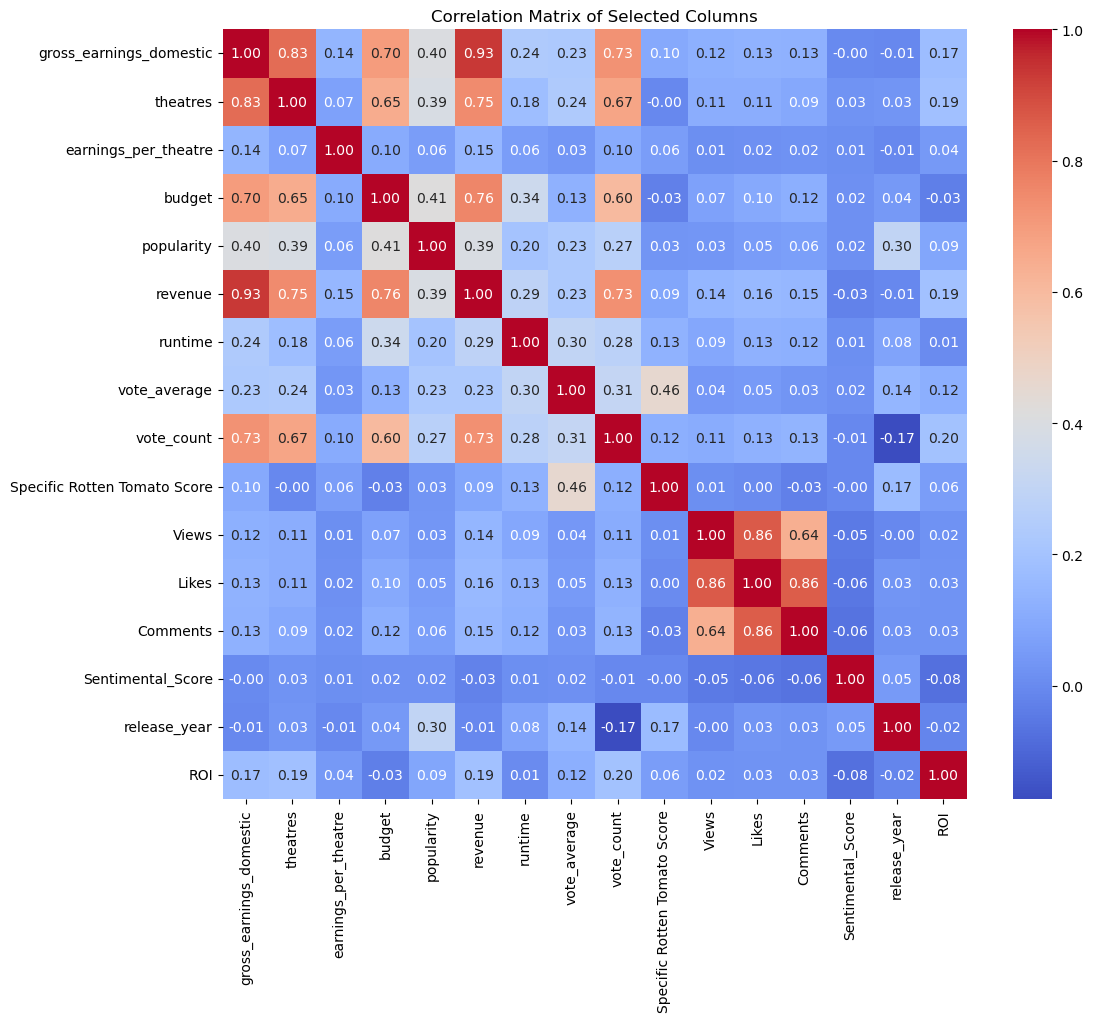

In [46]:

# Select the specific columns of interest from 'processed_df'
selected_columns = ['gross_earnings_domestic', 'theatres', 'earnings_per_theatre', 'budget',
                    'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count',
                    'Specific Rotten Tomato Score', 'Views', 'Likes', 'Comments',
                    'Sentimental_Score', 'release_year', 'ROI']

# Create a DataFrame containing only the selected columns
selected_df = processed_df[selected_columns]

# Calculate the correlation matrix for the selected columns
correlation_matrix = selected_df.corr()

# Create a heatmap plot of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Columns')
plt.show()


In [47]:
processed_df.describe()

,gross_earnings_domestic,theatres,earnings_per_theatre,budget,popularity,revenue,runtime,vote_average,vote_count,Specific Rotten Tomato Score,Views,Likes,Comments,Sentimental_Score,release_year,ROI
count,1.918000e+03,1918.000000,1918.000000,1.918000e+03,1918.000000,1.918000e+03,1918.000000,1918.000000,1918.000000,1918.000000,1.918000e+03,1.918000e+03,1918.000000,1743.000000,1918.000000,1918.000000
mean,4.689754e+07,62999.956204,inf,4.086210e+07,41.147657,1.248740e+08,111.061522,6.618128,2789.424922,62.388425,3.594060e+07,2.545472e+05,11196.065693,0.870236,2017.308133,2.384050
std,8.755420e+07,67528.863745,NaN,5.368887e+07,64.906708,2.408657e+08,19.116434,0.821628,3975.287860,27.234828,1.619695e+08,9.862790e+05,44319.054488,0.415605,2.950195,7.311939
min,8.800000e+01,0.000000,2.218750,1.500000e+04,0.600000,1.023200e+04,31.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,-0.999000,2013.000000,-0.999318
25%,1.156787e+06,4075.250000,248.584878,1.282088e+07,16.455250,4.883682e+06,97.000000,6.110500,366.250000,41.000000,1.260708e+06,7.202750e+03,316.250000,0.979200,2015.000000,-0.572866
50%,1.443631e+07,44340.000000,405.726303,1.500000e+07,25.205500,3.350552e+07,108.000000,6.652000,1271.000000,67.000000,5.374806e+06,2.877650e+04,1469.500000,0.993900,2017.000000,0.699758
75%,5.359307e+07,101431.750000,650.652657,4.500000e+07,43.448250,1.256815e+08,121.000000,7.174750,3441.500000,87.000000,1.758603e+07,1.075178e+05,5747.000000,0.997700,2019.000000,2.896406
max,8.583730e+08,481782.000000,inf,4.600000e+08,1064.930000,2.800000e+09,206.000000,8.515000,33016.000000,100.000000,3.282427e+09,1.581956e+07,730303.000000,0.999900,2023.000000,139.000000
